### Two styles of generator

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def residual_block(x, filters):
    """
    Create a residual block.
    
    Args:
    x: Input tensor.
    filters: Number of filters in the convolutional layers.
    
    Returns:
    A tensor representing the output of the residual block.
    """
    # Save the input tensor for the skip connection
    skip = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add the input tensor (skip connection) to the output tensor
    x = Add()([x, skip])
    
    # Apply the activation function
    x = Activation('relu')(x)
    
    return x

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def build_generator(input_shape):
    # Encoder
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Transformer
    for _ in range(10):
        x = residual_block(x, filters = 16)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    output_layer = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

    return Model(input_layer, output_layer)

### Two styles of discriminator

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def build_discriminator(input_shape):
    # Discriminator
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    output_layer = layers.Dense(1, activation='sigmoid')(x)

    return Model(input_layer, output_layer)

### StyleTransferGAN class

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
import numpy as np


def sample_images(content_batch, generated_images, epoch):
# Number of images to display
    num_images = min(5, len(generated_images))

    # Denormalize the generated images
    generated_images = 0.5 * (generated_images + 1)

    # Create a subplot for displaying images
    fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 6))
    for i in range(num_images):
        # Display content images
        axes[0, i].imshow(content_batch[i])
        axes[0, i].axis('off')

        # Display generated images
        axes[1, i].imshow(generated_images[i])
        axes[1, i].axis('off')

    # Save or display the images
    plt.savefig(f'samples/epoch_{epoch}.png')
    plt.show()



#def sample_input(content_batch, style_batch):

    #num_images = min(5, len(content_batch), len(style_batch))

    # Create a subplot for displaying images
    #fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 6))
    #for i in range(num_images):
        # Display content images
        #axes[0, i].imshow(content_batch[i])
        #axes[0, i].axis('off')

        # Display generated images
        #axes[1, i].imshow(style_batch[i])
        #axes[1, i].axis('off')




class StyleTransferGAN(Model):
    def __init__(self, input_shape):
        super(StyleTransferGAN, self).__init__()
        self.generator = build_generator(input_shape)
        self.discriminator = build_discriminator(input_shape)
        self.discriminator.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
        
        # Create the combined model for training the generator
        img = tf.keras.Input(shape=input_shape)
        generated_img = self.generator(img)
        self.discriminator.trainable = False
        valid = self.discriminator(generated_img)

        self.combined = Model(img, valid)
        self.combined.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')






    def train(self, content_generator, style_generator, epochs, batch_size=33, sample_interval = 5):

        # Load the generators
        self.content_generator = content_generator
        self.style_generator = style_generator


        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of content and style images
            content_batch = next(self.content_generator)
            style_batch = next(self.style_generator)

            current_batch_size = min(content_batch.shape[0], style_batch.shape[0])

            content_batch = content_batch[:current_batch_size]

            style_batch = style_batch[:current_batch_size]


            # Adversarial ground truths
            real = np.ones((current_batch_size, 1))
            fake = np.zeros((current_batch_size, 1))



            # Generate a batch of stylized images
            generated_images = self.generator.predict(content_batch)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(style_batch, real)
            d_loss_fake = self.discriminator.train_on_batch(generated_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # -----------------
            #  Train Generator
            # -----------------

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(content_batch, real)

            # If at the end of an interval, save and plot the progress
            if epoch % sample_interval == 0:

                #sample_input(content_batch, style_batch)

                print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
                sample_images(content_batch[:current_batch_size], generated_images, epoch)


    def predict(self, content_image):
        return self.generator.predict(content_image)


### Implementation

In [28]:
def preprocess_image(image):
    # Resize the image while maintaining its aspect ratio
    image = tf.image.resize_with_pad(image, target_height=256, target_width=256)
    
    # Normalize the pixel values to the range [0, 1]
    image = image / 255.0
    
    return image

In [29]:
image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image,
                                          rotation_range=10, # rotation
                                          width_shift_range=0.2, # horizontal shift
                                          height_shift_range=0.2, # vertical shift
                                          zoom_range=0.2, # zoom
                                          horizontal_flip=True#, # horizontal flip
                                          #brightness_range=[0.2,1.2]
                                          )

In [30]:
# Create a generator for your dataset
impressionism_generator = image_data_generator.flow_from_directory(
    directory='images/style/',
    color_mode="rgb", # for coloured images
    target_size=(256, 256),
    batch_size=50,
    class_mode=None
)

# Create a generator for the second folder
nature_photography_generator = image_data_generator.flow_from_directory(
    directory='images/content/',
    color_mode="rgb", # for coloured images
    target_size=(256, 256),
    batch_size=50,
    class_mode=None
)

test_generator =  image_data_generator.flow_from_directory(
    directory='images/test/',
    color_mode="rgb", # for coloured images
    target_size=(256, 256),
    batch_size=1,
    class_mode=None
)




Found 99 images belonging to 1 classes.
Found 99 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [31]:
test_image = next(test_generator)[0]

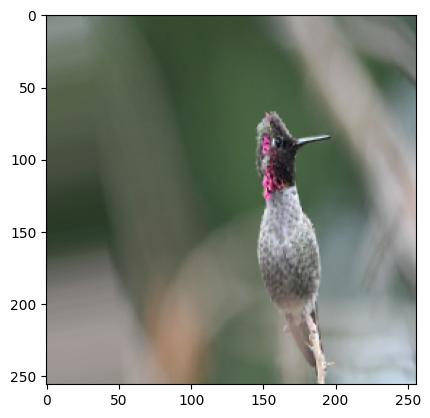

In [32]:
plt.imshow(test_image)
plt.show()

2/2 [==============================] - 5s 1s/step
0 [D loss: 3.0193139910697937] [G loss: 0.31361865997314453]


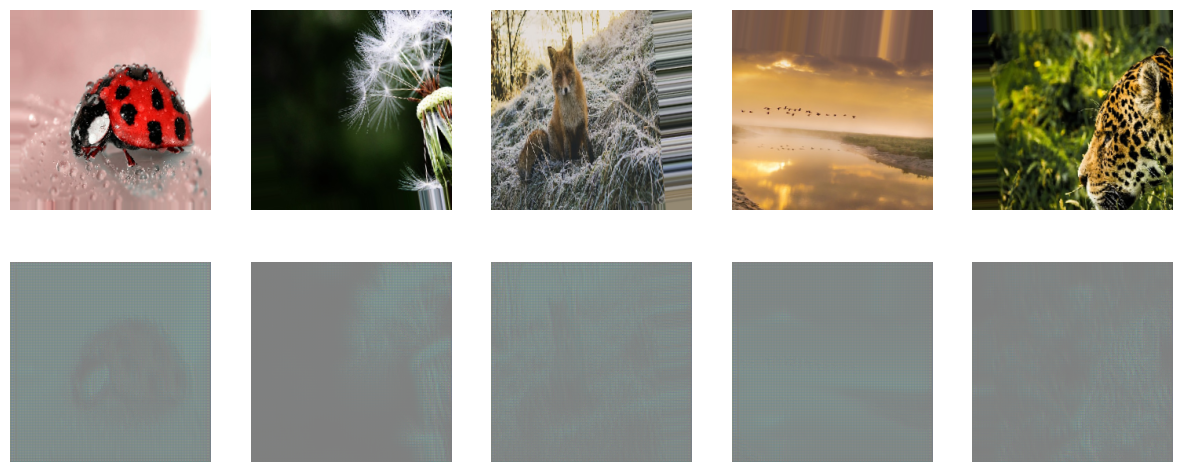

2/2 [==============================] - 5s 2s/step
5 [D loss: 0.06794038228690624] [G loss: 0.6836662888526917]


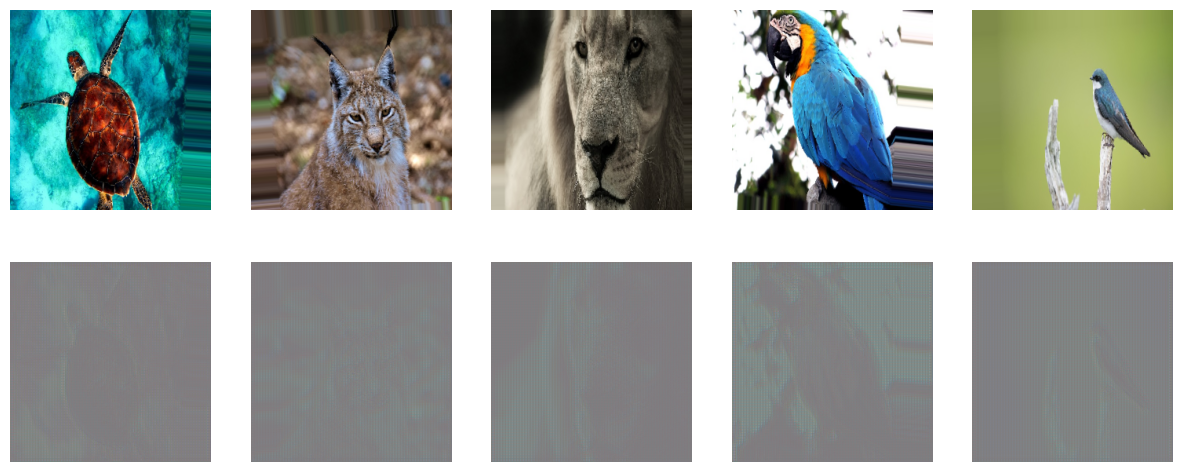

2/2 [==============================] - 5s 2s/step
10 [D loss: 0.1517382791498676] [G loss: 1.4438661336898804]


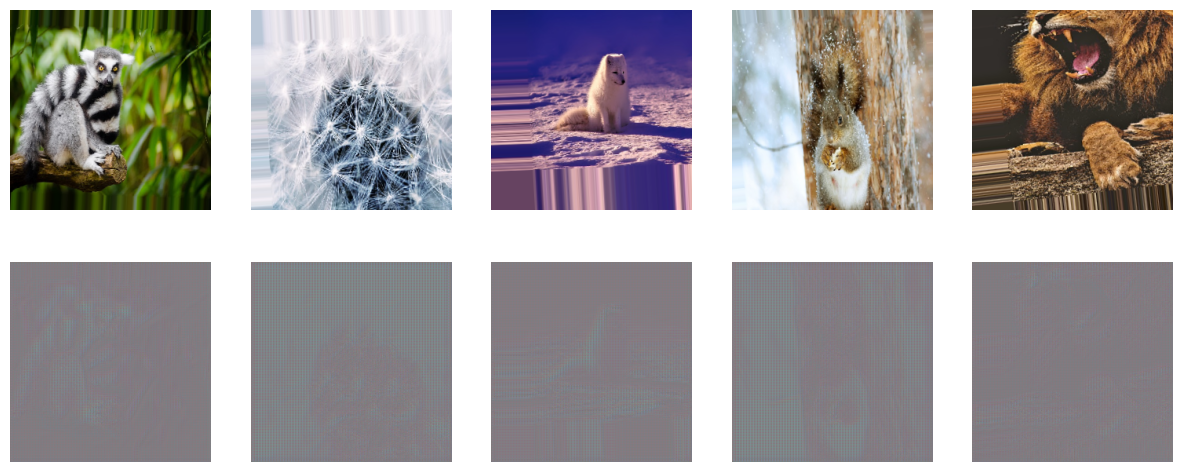

2/2 [==============================] - 5s 2s/step
15 [D loss: 9.929205015690723e-05] [G loss: 0.04512864351272583]


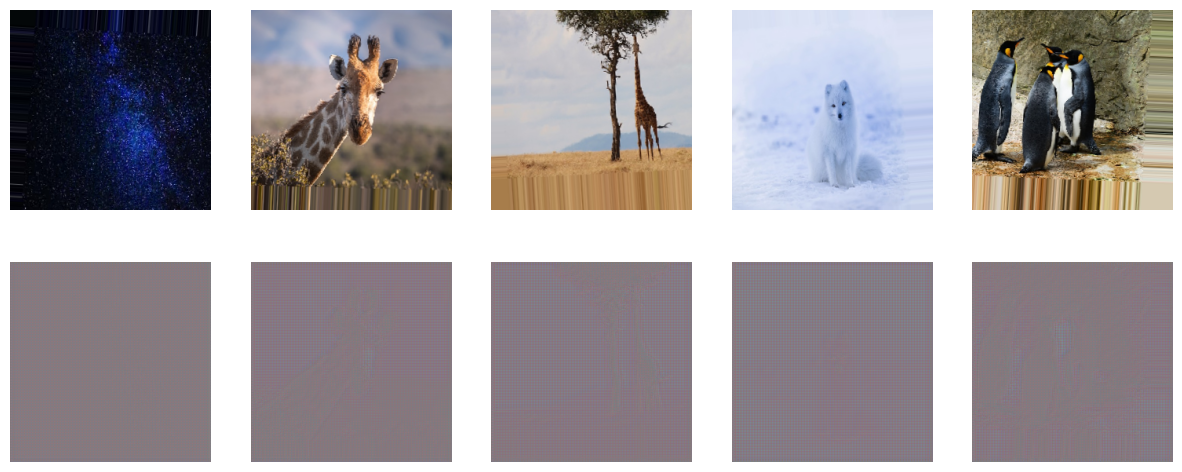

2/2 [==============================] - 5s 2s/step


KeyboardInterrupt: 

In [33]:

# Instantiate the StyleTransferGAN model
gan = StyleTransferGAN(input_shape=(256, 256, 3))

# Train the model using content_images and style_images
gan.train(nature_photography_generator, impressionism_generator, epochs=100, batch_size=32)



# Perform style transfer on a content image
#stylized_image = gan.predict(test_image)
